# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
import random

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

615

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
city, cloudiness, country, date, humidity, lat, lng, max_temp, wind_speed = ([] for i in range(9))
weather_data = dict()

for index, c in enumerate(cities, start=1):
    max_attempts = 10
    attempts = 0
    while attempts < max_attempts:
        url = "https://api.openweathermap.org/data/2.5/weather?q=" + c + "&appid=" + weather_api_key
        response = requests.get(url).json()
        if response['cod'] == 200:
            print(f'Processing record {index}, {c}')
            city.append(response['name'])
            cloudiness.append(response['clouds']['all'])
            country.append(response['sys']['country'])
            date.append(response['dt'])
            humidity.append(response['main']['humidity'])
            lat.append(response['coord']['lat'])
            lng.append(response['coord']['lon'])
            max_temp.append(response['main']['temp_max'])
            wind_speed.append(response['wind']['speed'])
            break

        elif response['cod'] == 429:
            print('API request limit, back off for 60 sec')  
            time.sleep((60) + random.random())
            attempts = attempts + 1

        else:
            print('City not found, skipping')
            break    

weather_data['City'] = city
weather_data['Cloudiness'] = cloudiness
weather_data['Country'] = country
weather_data['Date'] = date
weather_data['Humidity'] = humidity
weather_data['Lat'] = lat 
weather_data['Lng'] = lng
weather_data['Max Temp'] = max_temp
weather_data['Wind Speed'] = wind_speed
print('Completed!')

Processing record 1, new norfolk
Processing record 2, busselton
Processing record 3, san cristobal
Processing record 4, marzuq
Processing record 5, yinchuan
City not found, skipping
Processing record 7, mataura
Processing record 8, ushuaia
City not found, skipping
Processing record 10, bhusawal
Processing record 11, rocha
City not found, skipping
Processing record 13, hilo
Processing record 14, atuona
Processing record 15, east london
Processing record 16, faanui
Processing record 17, rikitea
Processing record 18, nishihara
City not found, skipping
Processing record 20, sao filipe
City not found, skipping
City not found, skipping
Processing record 23, lebu
City not found, skipping
Processing record 25, abakaliki
Processing record 26, curitibanos
Processing record 27, souillac
Processing record 28, mar del plata
Processing record 29, cape town
Processing record 30, albany
Processing record 31, punta arenas
Processing record 32, sola
Processing record 33, dikson
Processing record 34, tup

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
df = pd.DataFrame.from_dict(data=weather_data, orient='columns')

In [17]:
pd.to_datetime(df['Date'], unit='s').dt.date

0      2020-04-01
1      2020-04-01
2      2020-04-01
3      2020-04-01
4      2020-04-01
          ...    
554    2020-04-01
555    2020-04-01
556    2020-04-01
557    2020-04-01
558    2020-04-01
Name: Date, Length: 559, dtype: object

In [18]:
def kelvin_to_fahrenheit(k):
    c = float(k) - 273.15
    f = c * (9/5) + 32
    return f

In [19]:
def mps_to_mph(m):
    """ meter/second convert to mile/hour 
    """
    return 2.23694 * float(m)

In [20]:
# preprocessing data
df['Max Temp'] = df['Max Temp'].apply(kelvin_to_fahrenheit)
df['Wind Speed'] = df['Wind Speed'].apply(mps_to_mph)
df['Date'] = pd.to_datetime(df['Date'], unit='s').dt.date
df.to_csv(output_data_file, header=True, index=False)
print(df.count())
df.head()

City          559
Cloudiness    559
Country       559
Date          559
Humidity      559
Lat           559
Lng           559
Max Temp      559
Wind Speed    559
dtype: int64


,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,New Norfolk,75,AU,2020-04-01,87,-42.78,147.06,60.008,2.236940
1,Busselton,98,AU,2020-04-01,48,-33.65,115.33,66.002,13.533487
2,San Cristobal,75,VE,2020-04-01,88,7.77,-72.22,77.000,2.236940
3,Marzuq,9,YE,2020-04-01,26,14.40,46.47,87.710,13.958506
4,Yinchuan,60,CN,2020-04-01,13,38.47,106.27,41.000,4.004123


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

In [24]:
def draw_scatter(x_data, y_data, date, title, xlabel, ylabel, savefn, ylimit=None):
    fig, ax = plt.subplots()
    x = x_data
    y = y_data
    date_formatted = date.strftime("%Y-%b-%d")
    ax.scatter(x,y)
    ax.set_title(f"{title} ({date_formatted})")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylimit)
    ax.grid(True)
    fig.savefig(savefn)

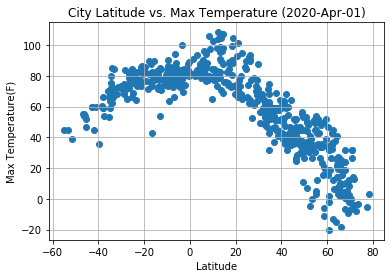

In [25]:
x = df['Lat']
y = df['Max Temp']
date = df['Date'][0]
draw_scatter(x, y, date, 'City Latitude vs. Max Temperature', 'Latitude', 'Max Temperature(F)', './output_data/fig1.png')

#### Latitude vs. Humidity Plot

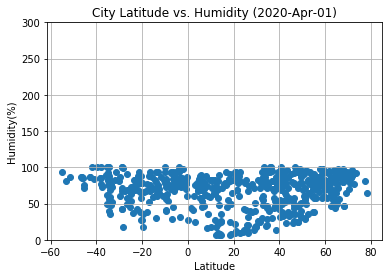

In [26]:
x = df['Lat']
y = df['Humidity']
date = df['Date'][0]
draw_scatter(x, y, date, 'City Latitude vs. Humidity', 'Latitude', 'Humidity(%)', "./output_data/fig2.png", (0,300))

**Latitude vs. Cloudiness Plot**

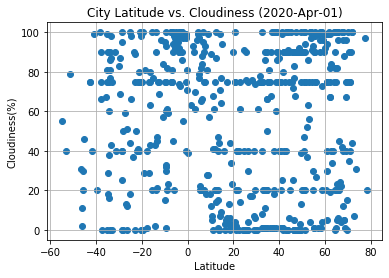

In [27]:
x = df['Lat']
y = df['Cloudiness']
date = df['Date'][0]
draw_scatter(x, y, date, 'City Latitude vs. Cloudiness', 'Latitude', 'Cloudiness(%)', "./output_data/fig3.png")

#### Latitude vs. Wind Speed Plot

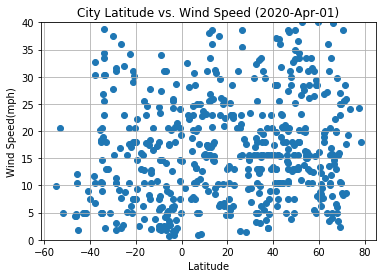

In [28]:
x = df['Lat']
y = df['Wind Speed'].apply(mps_to_mph)
date = df['Date'][0]
draw_scatter(x, y, date, 'City Latitude vs. Wind Speed', 'Latitude', 'Wind Speed(mph)', "./output_data/fig4.png", (0,40))

## Linear Regression

In [29]:
# OPTIONAL: Create a function to create Linear Regression plots
def draw_scatter_with_linear_reg(x, y, date, title, xlabel, ylabel, savefn, ylimit=None):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print(f'slope: {slope:.2f}, intercept: {intercept:.2f}')
    label = f'Y = {slope:.2f}X + {intercept:.2f}'
    print(f'The r-squared is:{r_value**2:.2f}')
    date_formatted = date.strftime("%Y-%b-%d")
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    ax.plot(x, intercept + slope * x, 'r', label=label)
    ax.set_title(f"{title} ({date_formatted})")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylimit)
    ax.legend()
    ax.grid(True)
    fig.savefig(savefn)

In [46]:
# Create Northern and Southern Hemisphere DataFrames
northern_hemi_df = df.loc[df['Lat'] >= 0]
southern_hemi_df = df.loc[df['Lat'] < 0]
northern_hemi_df.reset_index(drop=True, inplace=True)
southern_hemi_df.reset_index(drop=True, inplace=True)
northern_hemi_df.to_csv('./output_data/north_cities.csv', index=False)
southern_hemi_df.to_csv('./output_data/south_cities.csv', index=False)

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

slope: -1.28, intercept: 100.87
The r-squared is:0.81


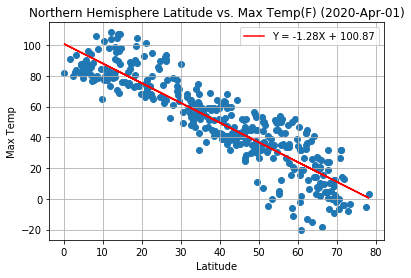

In [47]:
x = northern_hemi_df['Lat']
y = northern_hemi_df['Max Temp']
date = northern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Northern Hemisphere Latitude vs. Max Temp(F)', 'Latitude', 'Max Temp', "./output_data/fig5.png")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

slope: 0.56, intercept: 85.61
The r-squared is:0.47


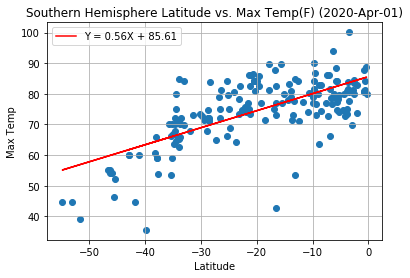

In [49]:
x = southern_hemi_df['Lat']
y = southern_hemi_df['Max Temp']
date = southern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Southern Hemisphere Latitude vs. Max Temp(F)', 'Latitude', 'Max Temp', "./output_data/fig6.png")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

slope: 0.39, intercept: 50.64
The r-squared is:0.10


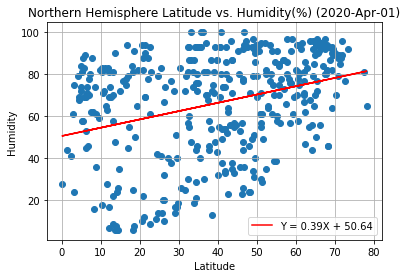

In [50]:
x = northern_hemi_df['Lat']
y = northern_hemi_df['Humidity']
date = northern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Northern Hemisphere Latitude vs. Humidity(%)', 'Latitude', 'Humidity', './output_data/fig7.png')

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

slope: -0.06, intercept: 72.27
The r-squared is:0.00


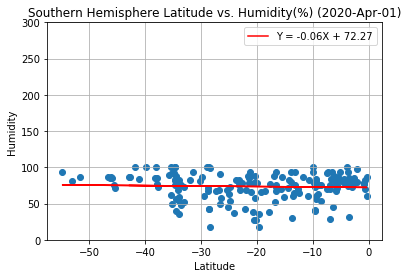

In [51]:
x = southern_hemi_df['Lat']
y = southern_hemi_df['Humidity']
date = southern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Southern Hemisphere Latitude vs. Humidity(%)', 'Latitude', 'Humidity', './output_data/fig8.png', (0,300))

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

slope: 0.24, intercept: 42.27
The r-squared is:0.02


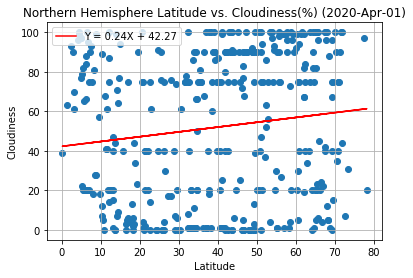

In [52]:
x = northern_hemi_df['Lat']
y = northern_hemi_df['Cloudiness']
date = northern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Northern Hemisphere Latitude vs. Cloudiness(%)', 'Latitude', 'Cloudiness', './output_data/fig9.png')

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

slope: 0.75, intercept: 78.51
The r-squared is:0.10


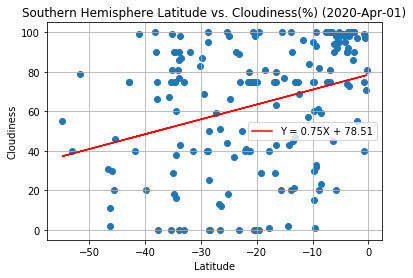

In [53]:
x = southern_hemi_df['Lat']
y = southern_hemi_df['Cloudiness']
date = southern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Southern Hemisphere Latitude vs. Cloudiness(%)', 'Latitude', 'Cloudiness', './output_data/fig10.png')

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

slope: 0.04, intercept: 7.70
The r-squared is:0.01


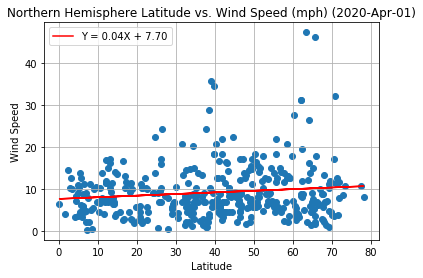

In [54]:
x = northern_hemi_df['Lat']
y = northern_hemi_df['Wind Speed']
date = northern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Northern Hemisphere Latitude vs. Wind Speed (mph)', 'Latitude', 'Wind Speed', './output_data/fig11.png')

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

slope: -0.04, intercept: 5.81
The r-squared is:0.01


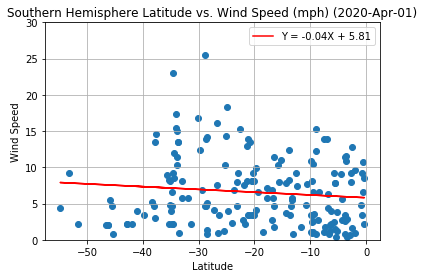

In [55]:
x = southern_hemi_df['Lat']
y = southern_hemi_df['Wind Speed']
date = southern_hemi_df['Date'][0]
draw_scatter_with_linear_reg(x, y, date, 'Southern Hemisphere Latitude vs. Wind Speed (mph)', 'Latitude', 'Wind Speed', './output_data/fig12.png', (0,30))